# Transfer Learning 練習

In [0]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
# import package
import cv2
import keras
from keras.applications.vgg16 import VGG16
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

## Cifar10 資料讀入及前處理

In [0]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [0]:
# image preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = np.array([cv2.resize(img, (64,64)) for img in x_train[:x_train.shape[0],:,:,:]])  # resize to 64x64
x_test = np.array([cv2.resize(img, (64,64)) for img in x_test[:x_test.shape[0],:,:,:]])  # resize to 64x64

x_train /= 255  # rescaling
x_test /= 255  # rescaling

In [5]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)

y_train shape: (50000, 10)


In [0]:
## result's dictionary
model_result = dict()
model_result['acc'] = dict()
model_result['loss'] = dict()
model_result['val_acc'] = dict()
model_result['val_loss'] = dict()

## 模型定義

In [20]:
#@title Model Structure { vertical-output: true }
transfer = False #@param {type:"boolean"}

# define model structure.
if transfer:
  input_tensor = Input(shape=x_train.shape[1:])
  res_model = VGG16(weights='imagenet', 
                    include_top=False,
                    input_tensor=input_tensor)
  
  model = Sequential()
  for l in res_model.layers:
    model.add(l)
  
  model.add(Flatten())
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  
else:
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
__________

In [0]:
# initiate optimizer
opt = keras.optimizers.adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Data Augmentation 參數設置

In [0]:
#@title Hyperparameter Setting { run: "auto", vertical-output: true }
data_augmentation = False #@param {type:"boolean"}
batch_size = 32 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}


In [0]:
#@title Data Augmentation Parameter Setting { run: "auto", vertical-output: true }
if data_augmentation:
  featurewise_center = False #@param {type:"boolean"}
  samplewise_center = False #@param {type:"boolean"}
  featurewise_std_normalization = False #@param {type:"boolean"}
  samplewise_std_normalization = False #@param {type:"boolean"}
  zca_whitening = False #@param {type:"boolean"}
  rotation_range = 0 #@param {type:"slider", min:0, max:180, step:1}
  width_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  height_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  horizontal_flip = True #@param {type:"boolean"}
  vertical_flip = False #@param {type:"boolean"}

## 開始訓練模型

In [24]:
#@title 默认标题文本 { vertical-output: true }
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=featurewise_center,  # set input mean to 0 over the dataset
        samplewise_center=samplewise_center,  # set each sample mean to 0
        featurewise_std_normalization=featurewise_std_normalization,  # divide inputs by std of the dataset
        samplewise_std_normalization=samplewise_std_normalization,  # divide each input by its std
        zca_whitening=zca_whitening,  # apply ZCA whitening
        rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=width_shift_range,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=height_shift_range,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=horizontal_flip,  # randomly flip images
        vertical_flip=vertical_flip,  # randomly flip images
        )  

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
18240/50000 [=========>....................] - ETA: 1:04 - loss: 1.5864 - acc: 0.4443

50000/50000 [==============================] - 105s 2ms/step - loss: 1.2978 - acc: 0.5428 - val_loss: 1.1857 - val_acc: 0.5961
Epoch 2/15
 2368/50000 [>.............................] - ETA: 1:34 - loss: 0.9630 - acc: 0.6601

49984/50000 [============================>.] - ETA: 0s - loss: 0.8734 - acc: 0.6938

50000/50000 [==============================] - 104s 2ms/step - loss: 0.8733 - acc: 0.6939 - val_loss: 0.7849 - val_acc: 0.7252
Epoch 3/15
14272/50000 [=======>......................] - ETA: 1:10 - loss: 0.7146 - acc: 0.7476

50000/50000 [==============================] - 103s 2ms/step - loss: 0.7216 - acc: 0.7473 - val_loss: 0.7961 - val_acc: 0.7261
Epoch 4/15
  800/50000 [..............................] - ETA: 1:37 - loss: 0.6333 - acc: 0.7850

49984/50000 [============================>.] - ETA: 0s - loss: 0.6138 - acc: 0.7843

50000/50000 [==============================] - 104s 2ms/step - loss: 0.6140 - acc: 0.7842 - val_loss: 0.9666 - val_acc: 0.6767
Epoch 5/15
14272/50000 [=======>......................] - ETA: 1:10 - loss: 0.5049 - acc: 0.8262

50000/50000 [==============================] - 103s 2ms/step - loss: 0.5137 - acc: 0.8226 - val_loss: 0.6946 - val_acc: 0.7670
Epoch 6/15
  768/50000 [..............................] - ETA: 1:37 - loss: 0.3493 - acc: 0.8789

49984/50000 [============================>.] - ETA: 0s - loss: 0.4209 - acc: 0.8522

50000/50000 [==============================] - 103s 2ms/step - loss: 0.4208 - acc: 0.8523 - val_loss: 0.7044 - val_acc: 0.7719
Epoch 7/15
14272/50000 [=======>......................] - ETA: 1:10 - loss: 0.3364 - acc: 0.8843

50000/50000 [==============================] - 103s 2ms/step - loss: 0.3511 - acc: 0.8770 - val_loss: 0.9165 - val_acc: 0.7197
Epoch 8/15
  832/50000 [..............................] - ETA: 1:36 - loss: 0.2571 - acc: 0.9147

49984/50000 [============================>.] - ETA: 0s - loss: 0.2856 - acc: 0.8995

50000/50000 [==============================] - 103s 2ms/step - loss: 0.2856 - acc: 0.8995 - val_loss: 0.7051 - val_acc: 0.7748
Epoch 9/15
14272/50000 [=======>......................] - ETA: 1:10 - loss: 0.2144 - acc: 0.9266

50000/50000 [==============================] - 103s 2ms/step - loss: 0.2380 - acc: 0.9162 - val_loss: 0.7211 - val_acc: 0.7875
Epoch 10/15
  832/50000 [..............................] - ETA: 1:36 - loss: 0.1706 - acc: 0.9399

49984/50000 [============================>.] - ETA: 0s - loss: 0.2015 - acc: 0.9299

50000/50000 [==============================] - 103s 2ms/step - loss: 0.2015 - acc: 0.9299 - val_loss: 0.7157 - val_acc: 0.7945
Epoch 11/15
14240/50000 [=======>......................] - ETA: 1:10 - loss: 0.1535 - acc: 0.9481

50000/50000 [==============================] - 103s 2ms/step - loss: 0.1812 - acc: 0.9376 - val_loss: 0.8024 - val_acc: 0.7655
Epoch 12/15
  800/50000 [..............................] - ETA: 1:38 - loss: 0.1476 - acc: 0.9475

46976/50000 [===========================>..] - ETA: 5s - loss: 0.1566 - acc: 0.9466

50000/50000 [==============================] - 103s 2ms/step - loss: 0.1583 - acc: 0.9463 - val_loss: 0.7920 - val_acc: 0.7858
Epoch 13/15
13120/50000 [======>.......................] - ETA: 1:12 - loss: 0.1226 - acc: 0.9577

50000/50000 [==============================] - 103s 2ms/step - loss: 0.1392 - acc: 0.9530 - val_loss: 0.9360 - val_acc: 0.7599
Epoch 14/15
  416/50000 [..............................] - ETA: 1:37 - loss: 0.1082 - acc: 0.9663

49984/50000 [============================>.] - ETA: 0s - loss: 0.1294 - acc: 0.9553

50000/50000 [==============================] - 103s 2ms/step - loss: 0.1294 - acc: 0.9553 - val_loss: 0.7976 - val_acc: 0.7909
Epoch 15/15
14208/50000 [=======>......................] - ETA: 1:10 - loss: 0.1063 - acc: 0.9634

50000/50000 [==============================] - 103s 2ms/step - loss: 0.1170 - acc: 0.9597 - val_loss: 0.8584 - val_acc: 0.7869


## 訓練結果視覺化

In [0]:
#@title Save Learning Result { vertical-output: true }
experiment = "Vanilla CNN" #@param {type:"string"}

model_result['acc'][experiment] = model.model.history.history.get('acc')
model_result['val_acc'][experiment] = model.model.history.history.get('val_acc')
model_result['loss'][experiment] = model.model.history.history.get('loss')
model_result['val_loss'][experiment] = model.model.history.history.get('val_loss')

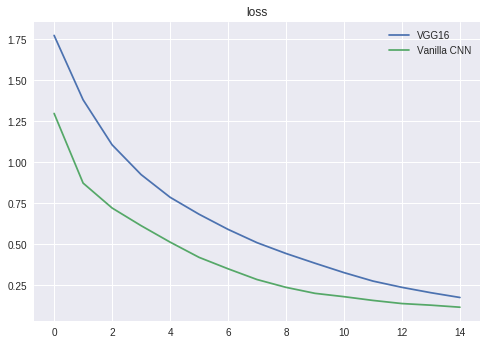

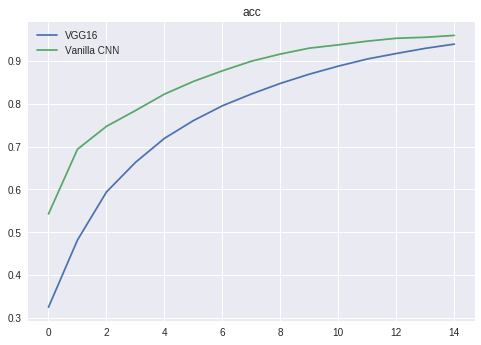

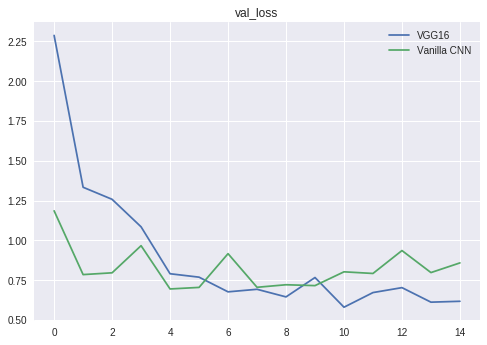

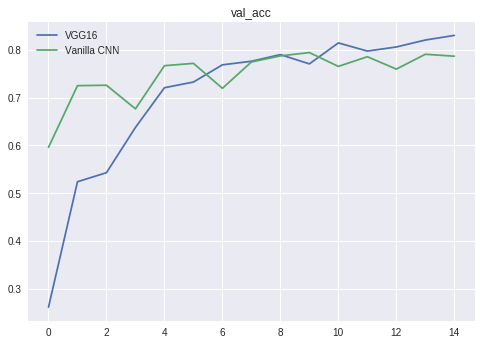

In [26]:
#@title Model Result { vertical-output: true }
import matplotlib.pyplot as plt

# training loss
for i in model_result['loss'].keys():
  plt.plot(np.arange(len(model_result['loss'][i])), model_result['loss'][i], label = i)

plt.legend(loc='best')
plt.title('loss')
plt.show()

# training acc
for i in model_result['acc'].keys():
  plt.plot(np.arange(len(model_result['acc'][i])), model_result['acc'][i], label = i)

plt.legend(loc='best')
plt.title('acc')
plt.show()

# valid loss
for i in model_result['val_loss'].keys():
  plt.plot(np.arange(len(model_result['val_loss'][i])), model_result['val_loss'][i], label = i)

plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for i in model_result['val_acc'].keys():
  plt.plot(np.arange(len(model_result['val_acc'][i])), model_result['val_acc'][i], label = i)

plt.legend(loc='best')
plt.title('val_acc')
plt.show()